In [77]:
import numpy as np
import xarray as xr
import sys
sys.path.append('../')
from xdispersion import RelativeDispersion
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from xdispersion import gen_rbins, rel_disp, rel_diff, kurtosis, cumul_inv_sep_time



In [78]:


drifters = xr.open_dataset('./QGdaphne-E06e-8/fort.1001.np4000nt2000.nc')

npa = drifters.dims['tracer'] #number particles

rd = RelativeDispersion(drifters, ragged=False, ID='tracer',
                        xpos='x', uvel='ux', time='time',
                        ypos='y', vvel='uy', coord='polar')

pairs = rd.get_all_pairs()
origin_pairs = rd.get_original_pairs(pairs, r0=[0.005, 0.01])
# This is equivalent to:
# condition = np.logical_and(pairs.r0>=0.18, pairs.r0<=0.22)
# origin_pairs = pairs.where(condition, drop=True).astype(pairs.dtypes)

origin_pairs

alpha = 1.2
rbins = gen_rbins(0.01, 0.5, alpha)

# get all building blocks for the four measures
rx, ry, rxy, r, rpb = rd.separation_measures(origin_pairs)


/tmp/ipykernel_128389/2510479222.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  npa = drifters.dims['tracer'] #number particles


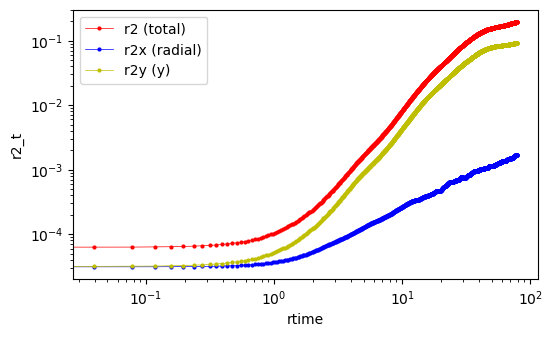

In [79]:

r2   = rel_disp(r, order=2, mean_at='const-t') #order=2 so 2nd moment of separation
r2x   = rel_disp(rx, order=2, mean_at='const-t') #x dispeersion
r2y   = rel_disp(ry, order=2, mean_at='const-t') #y dispersion

K2   = rel_diff(r, mean_at='const-t') #Relative diffusivity
K2x   = rel_diff(rx, mean_at='const-t') #Relative diffusivity

Ku   = kurtosis(r, mean_at='const-t') #kurtosis=4th moment
Kux   = kurtosis(rx, mean_at='const-t') #kurtosis=4th moment

plt.figure(figsize=(6, 3.5))
r2.plot.line(xscale='log', yscale='log', marker='o', color='r', markersize=2, lw=0.5,  label='r2 (total)')
r2x.plot.line(xscale='log', yscale='log', marker='o', color='b', markersize=2, lw=0.5, label='r2x (radial)')
r2y.plot.line(xscale='log', yscale='log', marker='o', color='y', markersize=2, lw=0.5, label='r2y (y)')
plt.legend()


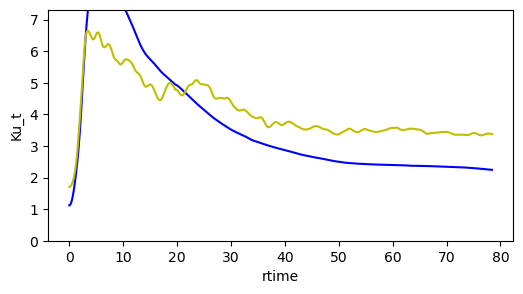

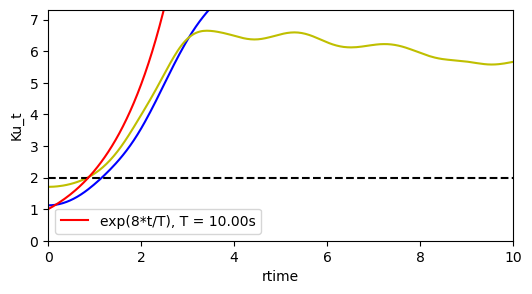

In [80]:
T=10

Ku.plot(xscale='linear', figsize=(6, 3), c='b')
Kux.plot(xscale='linear', c='y')
plt.ylim(0,1.1*Kux.max())

Ku.plot(xscale='linear', figsize=(6, 3), c='b')
Kux.plot(xscale='linear', c='y')
#plt.fill_between(Ku.rtime, lower, upper, alpha=0.2, color='b')
plt.plot(Ku.rtime,Ku.rtime*0+2,'--k')
plt.xlim(0,10)
plt.ylim(0,1.1*Kux.max())
plt.plot(Ku.rtime.values[:150], np.exp(8 * Ku.rtime.values[:150]/T), 'r-', label=f'exp(8*t/T), T = {T:.2f}s')
plt.legend()



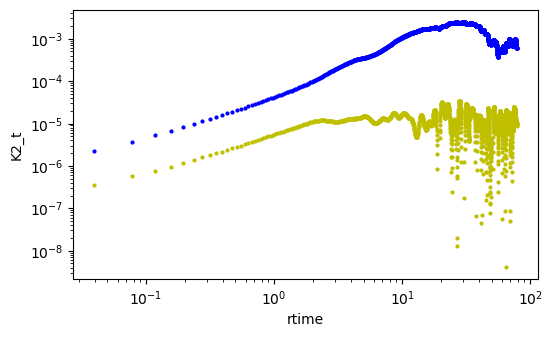

In [81]:
K2.plot(xscale='log', yscale='log', figsize=(6,3.5), marker='o', color='b', markersize=2, lw=0)
K2x.plot(xscale='log', yscale='log',  marker='o', color='y', markersize=2, lw=0)


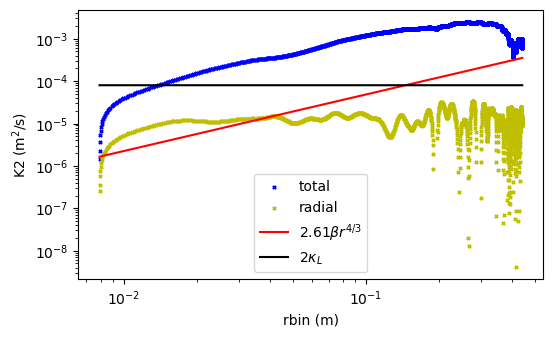

In [82]:
beta = 4e-4
kappal= 4e-5

rtmp = np.sqrt(r2)

plt.figure(figsize=(6, 3.5))
plt.scatter(rtmp.values,K2.values,marker='x',s=5,color='b', label='total')
plt.scatter(rtmp.values,K2x.values,marker='x',s=5,color='y', label='radial')
plt.plot(rtmp,2.61*beta*rtmp**(4/3),color='r',label=r'$2.61 \beta r^{4/3}$')
plt.plot(rtmp,rtmp*0+2*kappal,'k',label=r'$2\kappa_L$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rbin (m)')
plt.ylabel('K2 (m$^2$/s)')
plt.legend()

## Calculate CIST on total and radial dispersion

In [83]:
from xdispersion import * 

PDFtot=prob_dens_func(r,rbins)
CDFtot = cumul_dens_func(PDF,rbins)
PDFx=prob_dens_func(rx,rbins)
CDFx = cumul_dens_func(PDFx,rbins)

#Chose which CDF to work with in following
CDF=CDFx

/home/dgsl1/miniforge3/envs/xdispersion/lib/python3.13/site-packages/xhistogram/core.py:462: RuntimeWarning: invalid value encountered in divide
  h = bin_counts / bin_areas / reshape(bin_count_sums, bin_count_sums_shape)
/home/dgsl1/miniforge3/envs/xdispersion/lib/python3.13/site-packages/xhistogram/core.py:462: RuntimeWarning: invalid value encountered in divide
  h = bin_counts / bin_areas / reshape(bin_count_sums, bin_count_sums_shape)


In [84]:
#from xdispersion import exp_decay_offset_fit

A_exp, tau_exp, t0_exp, C_exp, rmse_exp = xr.apply_ufunc(
    exp_decay_offset_fit,
    CDF['rtime'],
    CDF,
    dask='allowed',
    input_core_dims=[['rtime'], ['rtime']],
    output_core_dims=[[], [], [], [], []],
    vectorize=True
)

print(tau_exp)


<xarray.DataArray (rbin: 21)> Size: 168B
array([2.76619515e+00, 6.73395494e+00, 1.09945671e+01, 1.54044706e+01,
       2.03022530e+01, 2.68528891e+01, 3.75315786e+01, 6.20336167e+01,
       2.43030114e+02, 2.99934371e+05, 2.56995590e+04, 6.79788677e+05,
       1.25723403e+01, 3.33353692e+02, 2.91876766e-01, 2.14021586e-01,
       2.14021586e-01, 2.14021586e-01, 2.14021586e-01, 2.14021586e-01,
       2.14021586e-01])
Coordinates:
  * rbin     (rbin) float64 168B 0.012 0.0144 0.01728 ... 0.3195 0.3834 0.4601


/home/dgsl1/Documents/GitHub/xdispersion/data_daphne/../xdispersion/utils.py:208: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(model, t_fit, y_fit, p0=[A0, tau0, t0_0, C0], maxfev=10000)


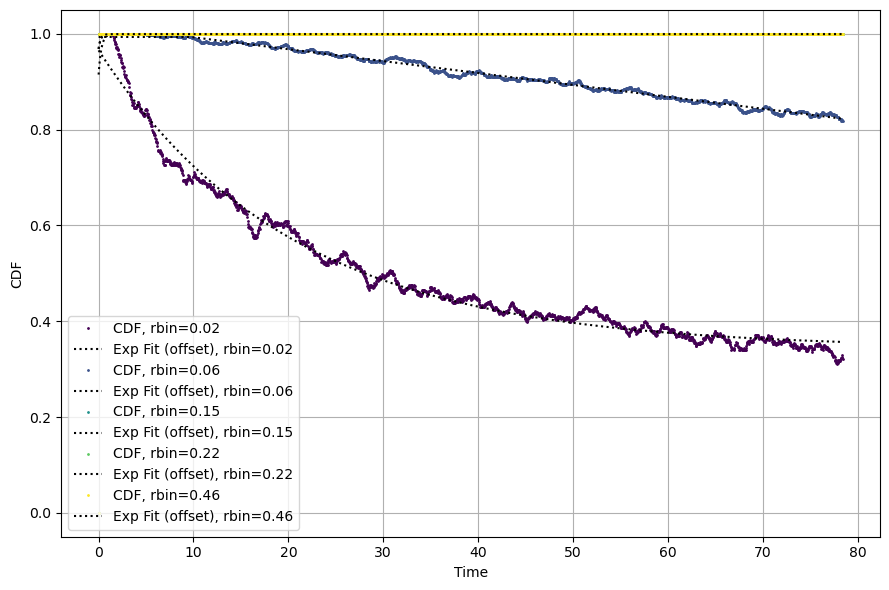

In [85]:

# Select fixed rbin values
rbins_to_plot = [rbins.values[5],rbins.values[10], rbins.values[15], rbins.values[17], rbins.values[21]]  # example rbin values

# Choose a colormap and get distinct colors
colors = cm.viridis(np.linspace(0, 1, len(rbins_to_plot)))

plt.figure(figsize=(9, 6))
for i, rb in enumerate(rbins_to_plot):
    # Raw CDF
    cdf_line = CDF.sel(rbin=rb, method='nearest')
    rtime_vals = cdf_line['rtime'].values
    cdf_vals = cdf_line.values
    rb_val = cdf_line.rbin.values

    plt.plot(rtime_vals, cdf_vals, 'o', markersize=1, color=colors[i], label=f'CDF, rbin={rb_val:.2f}')

    # Exponential fit
    A = A_exp.sel(rbin=rb, method='nearest').values
    tau = tau_exp.sel(rbin=rb, method='nearest').values
    t0 = t0_exp.sel(rbin=rb, method='nearest').values
    C = C_exp.sel(rbin=rb, method='nearest').values

    if np.all(np.isfinite([A, tau, t0, C])):
        t_vals = rtime_vals
        t_shifted = t_vals - t0
        exp_fit = np.where(t_shifted >= 0, A * np.exp(-t_shifted / tau) + C, A + C)
    
        #plt.plot(t_vals, exp_fit, ':', color=colors[i], label=f'Exp Fit (offset), rbin={rb_val:.2f}')
        plt.plot(t_vals, exp_fit, ':', color='black', label=f'Exp Fit (offset), rbin={rb_val:.2f}')


plt.xlabel('Time')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [86]:
# Compute t₀.₅ (time where CDF = 0.5)
valid_mask = np.logical_and(
    A_exp > 0,
    np.logical_and(tau_exp > 0, (0.5 - C_exp) / A_exp > 0)
)

t_half_exp = xr.where(
    valid_mask,
    t0_exp - tau_exp * np.log((0.5 - C_exp) / A_exp),
    np.nan
)

# Compute Δt_half and its inverse
dt_half = t_half_exp.diff('rbin')
CIST_exp = 1.0 / dt_half

# rbin values corresponding to upper bins in diff
rbin_upper = t_half_exp['rbin'][1:]

/home/dgsl1/miniforge3/envs/xdispersion/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


/tmp/ipykernel_128389/3294058101.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[0].set_ylim(0,10**4)


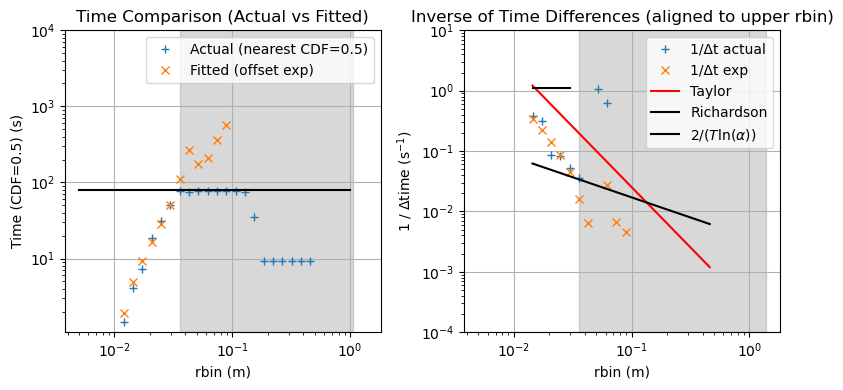

In [87]:
# Find the index of the value in the CDF nearest to 0.5 (to compare with the fit)
idx_nearest = abs(CDF - 0.5).argmin(dim='rtime')
t_half_actual = CDF['rtime'].isel(rtime=idx_nearest)

# Find rbin_max where t_half_actual is closest to tmax 
tmax = CDF.rtime.values.max()
tol = 0.1 * tmax # Define tolerance
mask = np.abs(t_half_actual - tmax) <= tol # Mask rbin values within ±5% of tmax
rbin_candidates = CDF.rbin.where(mask, drop=True) # Get the smallest rbin that satisfies the condition
if rbin_candidates.size > 0:
    rbin_max = rbin_candidates.min().item()
else:
    rbin_max = CDF.rbin.max().item()

# Compute inverse of time differences (Δt⁻¹)
inv_diff_actual = 1.0 / t_half_actual.diff('rbin')
inv_diff_exp = 1.0 / t_half_exp.diff('rbin')
# Use the *upper* bin of each pair for x-axis
#rbin_upper = CDF.rbin.isel(rbin=slice(1, None))

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

# --- Subplot 1: Time where CDF = 0.5 ---
axs[0].plot(CDF.rbin, t_half_actual, '+', label='Actual (nearest CDF=0.5)')
axs[0].plot(CDF.rbin, t_half_exp, 'x', label='Fitted (offset exp)')
axs[0].plot([0.005,1],[tmax,tmax],color='k')
axs[0].axvspan(rbin_max, axs[0].get_xlim()[1], color='gray', alpha=0.3) # Shade rbin > rbin_max
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('rbin (m)')
axs[0].set_ylabel('Time (CDF=0.5) (s)')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Time Comparison (Actual vs Fitted)')
axs[0].set_ylim(0,10**4)

# --- Subplot 2: Inverse Time Differences ---
axs[1].plot(rbin_upper, inv_diff_actual, '+', label='1/Δt actual')
axs[1].plot(rbin_upper, inv_diff_exp, 'x', label='1/Δt exp')
axs[1].plot(rbin_upper, 4*kappal*np.log(2)/(alpha**2-1)*rbin_upper**(-2), 'r-', label=r'Taylor')
axs[1].plot(rbin_upper, 4*beta*2.6741/(9*(alpha**(2/3)-1))*rbin_upper**(-2/3), 'k-', label=r'Richardson')
axs[1].plot(rbin_upper[:5], rbin_upper[:5]*0+2/T/np.log(alpha), 'k-',label=r'$2 / (T \ln(\alpha))$')
axs[1].axvspan(rbin_max, axs[1].get_xlim()[1], color='gray', alpha=0.3) # Shade rbin > rbin_max
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('rbin (m)')
axs[1].set_ylabel('1 / Δtime (s$^{-1}$)')
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Inverse of Time Differences (aligned to upper rbin)')
axs[1].set_ylim(10**(-4),10)

plt.tight_layout()
plt.show()